 <figure>
 <img src="https://1000marcas.net/wp-content/uploads/2020/11/Python-logo.png" width="200" height="200" align="center" />
 </figure>





# <span style="color:#F72585"><center>Predicción del valor de las acciones en la bolsa</center></span>

#Librerias


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#importing required libraries
from sklearn.preprocessing import MinMaxScaler

# importa objetos de keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
print("Versión de Tensorflow: ", tf.__version__)

# optimizador
from tensorflow.keras.optimizers import Adam

#Early
from tensorflow.keras.callbacks import EarlyStopping


Versión de Tensorflow:  2.12.0


In [2]:
pip install torch pytorch-lightning pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer, TemporalFusionTransformer

1. Suscríbase a las API de Yahoo-Finance y Alpha-Vantage.
Dentro de Yahoo-Finance buscamos la empresa de nuestra elección.

En este caso seleccionamos [Amazon](https://finance.yahoo.com/quote/AMZN/history?p=AMZN).

2. Baje un conjunto de datos que incluya la mayor cantidad de datos para un conjunto de empresas seleccionadas por usted.


Descargamos el archivo [AMZN.csv](https://github.com/LoanaBeltran/Inteligencia-Artificial/blob/cec966a7a633291f3c6f8f50fc0dac63c2a6521f/Dimplomado_Ciencia_Datos/Tareas/imagen/AMZN.csv) el cual subiremos a nuestra carpeta de archivos.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving AMZN.csv to AMZN (1).csv


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['AMZN.csv']))
df2 = pd.read_csv(io.BytesIO(uploaded['AMZN.csv']))

In [6]:
print('\n Shape of the data:')
print(df.shape)
df.head()


 Shape of the data:
(3775, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-03-24,3.6910,3.8465,3.6375,3.7975,3.7975,187908000
1,2008-03-25,3.7915,3.8145,3.7025,3.7585,3.7585,126550000
2,2008-03-26,3.7070,3.7560,3.6620,3.6900,3.6900,125702000
3,2008-03-27,3.7185,3.7345,3.5400,3.5400,3.5400,158848000
4,2008-03-28,3.5500,3.6105,3.4630,3.4880,3.4880,105582000


In [7]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
# df = df.sort_index(ascending=True, axis=0)
data = pd.DataFrame(df[['Date', 'Close']])
data2=pd.DataFrame(df)
#
#setting index
data.index = data.Date
data.drop('Date', axis=1, inplace=True)
data.head()

data2.index = data2.Date
data2.drop('Date', axis=1, inplace=True)
data2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-03-24,3.6910,3.8465,3.6375,3.7975,3.7975,187908000
2008-03-25,3.7915,3.8145,3.7025,3.7585,3.7585,126550000
2008-03-26,3.7070,3.7560,3.6620,3.6900,3.6900,125702000
2008-03-27,3.7185,3.7345,3.5400,3.5400,3.5400,158848000
2008-03-28,3.5500,3.6105,3.4630,3.4880,3.4880,105582000


4. Construya un modelo predictivo con un horizonte de tamaño n, que usted define de acuerdo con la longitud del periodo de cada observación. Mínimo 5 observaciones adelante.mpetodo

In [8]:
# plot
len_data = len(data)
len_train = int(len_data*0.8) # 80%  = 3019
len_test = len_data- len_train # 20% = 2415
print (len_data, '=', len_train, '+',len_test)

3775 = 3020 + 755


In [9]:
# plot
len_data = len(data2)
len_train = int(len_data*0.8) # 80%  = 3019
len_test = len_data- len_train # 20% = 2415
print (len_data, '=', len_train, '+',len_test)

3775 = 3020 + 755


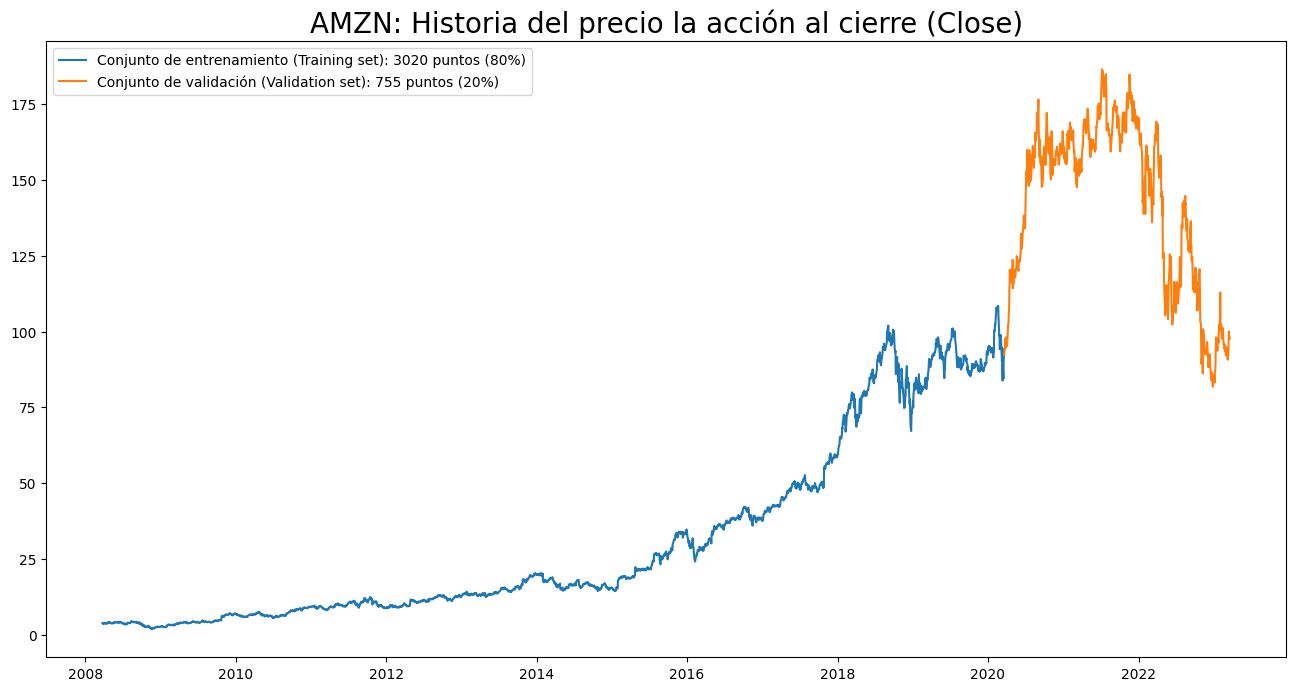

In [10]:
plt.figure(figsize=(16,8))
plt.plot(data[:len_train], label='Conjunto de entrenamiento (Training set): {} puntos (80%)'.format(len_train))
plt.plot(data['Close'][len_train:], label='Conjunto de validación (Validation set): {} puntos (20%)'.format(len_test)) #248 data
plt.title("AMZN: Historia del precio la acción al cierre (Close)", size = 20)
plt.legend()
plt.show()

In [11]:
#creating train and test sets
dataset = data.values
# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])

In [12]:
#creating train and test sets
dataset = data2.values
# create the scaler object and scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_data = np.array(scaler.fit_transform(dataset))

dataset2 = np.array(scaler.fit_transform(dataset))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)))
# dataset = pd.DataFrame(scaled_data,index=data.index, columns=['serie'])


In [13]:
dataset.shape

(3775, 6)

In [14]:
print(dataset2)

[[0.01038906 0.01015779 0.01039565 0.01107029 0.01107029 0.14826598]
 [0.01093102 0.0099864  0.01075063 0.01085927 0.01085927 0.09484105]
 [0.01047534 0.00967307 0.01052945 0.01048864 0.01048864 0.09410269]
 ...
 [0.50683662 0.5304653  0.51268807 0.53180952 0.53180952 0.05818153]
 [0.52862317 0.52869783 0.52279152 0.52591183 0.52591183 0.06055534]
 [0.52118125 0.51702159 0.51317956 0.51920258 0.51920258 0.03897544]]


In [15]:
def multipaso_data(dataset, target, start_index, end_index, history_size,
                      target_size,  single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

Se coloca una semilla para gerantizar reproductibidad

In [16]:
tf.random.set_seed(100)

In [17]:
#
# hiperparámetros para crear las secuencias
#
# tamaño de pasos a futuro
future_target = 10

# tamaño secuencias de entrada
past_history = 60

TRAIN_SPLIT = int(len_data*0.8) #3020: nuḿer0 de datos entreno

# Crea los datos
X_train, y_train = multipaso_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
X_test, y_test = multipaso_data(dataset, dataset, TRAIN_SPLIT,
                                                 None, past_history,
                                                 future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

3020
(2960, 60, 6)
(2960, 10, 6)
(685, 60, 6)
(685, 10, 6)


In [18]:
#
# hiperparámetros para crear las secuencias
#
# tamaño de pasos a futuro
future_target = 10

# tamaño secuencias de entrada
past_history = 60

TRAIN_SPLIT = int(len_data*0.8) #3020: nuḿer0 de datos entreno

# Crea los datos
X_train, y_train = multipaso_data(dataset2, dataset2, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
X_test, y_test = multipaso_data(dataset2, dataset2, TRAIN_SPLIT,
                                                 None, past_history,
                                                 future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#3020
#(2960, 60)
#(2960, 10)
#(685, 60)
#(685, 10)

3020
(2960, 60, 6)
(2960, 10, 6)
(685, 60, 6)
(685, 10, 6)


In [19]:
# shapes
input_shape = (X_train.shape[1], 1)
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.0, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.0, name= 'Dropout_02')(x)
outputs = Dense(future_target)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 60, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


In [20]:
# shapes
input_shape = (X_train.shape[1], 1)
units = 50

# layers
inputs = Input(input_shape)
x = Dropout(0.0, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer')(x)
#x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
#x = Dropout(0.4)
#x = LSTM(units=units//2, name='LSTM_layer_2')(x)
#x = Dropout(0.4)
x = Dropout(0.0, name= 'Dropout_02')(x)
outputs = Dense(future_target)(x)

# model
model_01 = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
model_01.summary()

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 1)]           0         
                                                                 
 Dropout_01 (Dropout)        (None, 60, 1)             0         
                                                                 
 LSTM_layer (LSTM)           (None, 50)                10400     
                                                                 
 Dropout_02 (Dropout)        (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 10,910
Trainable params: 10,910
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_01.compile(loss='mean_squared_error',
  optimizer=Adam(0.001))

In [23]:
#history = model_01.fit(X_train,y_train,epochs=20,batch_size=32)
history = model_01.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Epoch 1/40


ValueError: ignored

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_test.shape

In [ ]:
# predictions
prediction = model_01.predict(X_test)
#prediction = scaler.inverse_transform(prediction)

In [ ]:
print(X_test.shape)
print(prediction.shape)
print(y_test.shape)

In [ ]:
pred =0
y_train_p = X_test[pred,:]
y_test_p = y_test[pred,:]
y_pred_p = prediction[pred,:]

#print(y_train_p.shape)
#print(y_test_p.shape)
#print(y_pred_p.shape)

In [ ]:
plt.plot(np.arange(0, len(y_train_p)), y_train_p, 'g', label="historia")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_test_p, marker='.', label="verdadero")
plt.plot(np.arange(len(y_train_p), len(y_train_p) + len(y_test_p)), y_pred_p, 'r', label="predicción")
#plt.ylabel('Valor')
plt.xlabel('Time Step')
plt.title("Amazon: Historia del precio la acción al cierre. Escala (0,1)", size = 20)
plt.legend()
plt.show();

In [ ]:
model_01.save('../Datos/modelo_Apple_3_dia_multipl3.h5')

In [ ]:
model_01.get_config()

In [ ]:
df.head()
df.info()

In [ ]:
df1 = df.loc[:, df.columns != 'Date']
df1.head()
df1.info()
print(3775*6)
print(df.index)

In [ ]:
df_list = []

for label in df1:

    ts = df1[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    tmp = pd.DataFrame({'Num': ts})
    tmp['index']=df2.index
    date = tmp.index
    tmp['date'] = date
    tmp['Variable'] = label

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)
#22649


In [ ]:
time_df.tail(
)

In [ ]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

max_prediction_length = 7
max_encoder_length = 21

training = TimeSeriesDataSet(
    time_df,
    time_idx="index",
    target="Num",
    group_ids=["Variable"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Variable"],
    time_varying_unknown_reals=['Num'],
    target_normalizer=GroupNormalizer(
        groups=["Variable"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:

validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()